### Data Dictionary

**Beetles table**
* ID: beetle ID (unique integer)
* Group: flight test group (A, B, C, D)
* Sex: M, F
* date_treated
* date_dead
* OrNV detected: t, f
* Notes

**Observations table**

This table is not in standard format. It is a matrix with 'ID' as the first column.
The remaining columns labeled '2023/02/28', '2023/03/01', ... contain observation codes for each beetle.
The dates indicate when the observation was made. 
For example, an F in column 2023/02/28 indicates that this beetle flew during the previous night ( 2023-02-27 19:00 to 2023-02-28 07:00. 

* F: beetle flew (collected from bottom of chamber)
* N: beetle did not fly (collected from paint bucket)
* D: dead
* M: missing

In [1]:
import pandas as pd
import plotly.express as px

# GET DATA

In [2]:
SHEET_ID = '1jwgm7h_-Al4MspsfC4sP6E03QrjpZcTPr2JC7WLU2QM'

In [3]:
def get_google_sheet(sheet_id, sheet_name):
    """
    Returns a data frame generated from a Google sheet
    """
    url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
    return pd.read_csv(url)

# SHEET_ID = '1jwgm7h_-Al4MspsfC4sP6E03QrjpZcTPr2JC7WLU2QM'
# get_google_sheet(SHEET_ID, 'Flights')

In [4]:
# get 'beetles' table

df_beetles = get_google_sheet(SHEET_ID, 'Beetles')

# remove columns after 'Notes'
df_beetles = df_beetles.loc[:,:'Notes']
df_beetles

,ID,Group,Sex,date treated,date dead,OrNV detected,Notes
0,1,A,NaN,NaN,NaN,NaN,NaN
1,2,A,NaN,NaN,NaN,NaN,NaN
2,3,A,NaN,NaN,NaN,NaN,NaN
3,4,A,NaN,NaN,NaN,NaN,NaN
4,5,A,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
110,111,D,NaN,NaN,NaN,NaN,NaN
111,112,D,NaN,NaN,NaN,NaN,NaN
112,113,D,NaN,NaN,NaN,NaN,NaN
113,114,D,NaN,NaN,NaN,NaN,NaN


In [5]:
# get observations table

df_observations = get_google_sheet(SHEET_ID, 'Observations')

# No idea why the first column is unnamed, but this fixes the problem
df_observations.rename(columns={'Unnamed: 0':'ID'}, inplace=True)

# Drop all columns which do not contain data
df_observations.dropna(axis='columns', how='all', inplace=True)

# Convert the table into a more standard format
df_observations = df_observations.melt(id_vars='ID')

df_observations

,ID,variable,value
0,1,2023/02/28,N
1,2,2023/02/28,N
2,3,2023/02/28,N
3,4,2023/02/28,N
4,5,2023/02/28,N
...,...,...,...
1950,111,2023/03/16,NaN
1951,112,2023/03/16,NaN
1952,113,2023/03/16,NaN
1953,114,2023/03/16,NaN


In [6]:
# Merge tables using ID as key

df_merged = df_beetles.merge(df_observations)

# Drop all columns which do not contain data
df_merged.dropna(axis='columns', how='all', inplace=True)

# Rename
df_merged.rename(columns={'variable':'date', 'value':'obs'}, inplace=True)

# Select the rows we are interested in
# df_merged = df_merged.query('obs.str.contains("F") | obs.str.contains("N")')

df_merged

,ID,Group,date dead,Notes,date,obs
0,1,A,NaN,NaN,2023/02/28,N
1,1,A,NaN,NaN,2023/03/01,N
2,1,A,NaN,NaN,2023/03/02,F
3,1,A,NaN,NaN,2023/03/03,F
4,1,A,NaN,NaN,2023/03/04,NaN
...,...,...,...,...,...,...
1950,115,D,NaN,NaN,2023/03/12,NaN
1951,115,D,NaN,NaN,2023/03/13,NaN
1952,115,D,NaN,NaN,2023/03/14,NaN
1953,115,D,NaN,NaN,2023/03/15,NaN


In [7]:
# Select rows where obs contains 'F' (flew) or 'N' (did not fly)
df_merged.query("obs.str.contains('F') | obs.str.contains('N')")

# Create a new column 'flew'
df_merged['flew'] = df_merged.obs.str.contains('F')

df_merged

,ID,Group,date dead,Notes,date,obs,flew
0,1,A,NaN,NaN,2023/02/28,N,False
1,1,A,NaN,NaN,2023/03/01,N,False
2,1,A,NaN,NaN,2023/03/02,F,True
3,1,A,NaN,NaN,2023/03/03,F,True
4,1,A,NaN,NaN,2023/03/04,NaN,NaN
...,...,...,...,...,...,...,...
1950,115,D,NaN,NaN,2023/03/12,NaN,NaN
1951,115,D,NaN,NaN,2023/03/13,NaN,NaN
1952,115,D,NaN,NaN,2023/03/14,NaN,NaN
1953,115,D,NaN,NaN,2023/03/15,NaN,NaN


In [8]:
# Create a new dataframe containing only the columns we need

df = df_merged[['Group','date','flew']]
df

,Group,date,flew
0,A,2023/02/28,False
1,A,2023/03/01,False
2,A,2023/03/02,True
3,A,2023/03/03,True
4,A,2023/03/04,NaN
...,...,...,...
1950,D,2023/03/12,NaN
1951,D,2023/03/13,NaN
1952,D,2023/03/14,NaN
1953,D,2023/03/15,NaN


In [9]:
def proportion_flew(df):
    """ returns proportion of beetles which flew """
    return df.flew.sum() / df.flew.count()

# proportion_flew(df)

In [10]:
# calculate proportion of beetles which flew for each 'Group' and 'date'
gb = df.groupby(['Group','date']).apply(proportion_flew)
gb

/tmp/ipykernel_336948/1615604667.py:3: RuntimeWarning: invalid value encountered in long_scalars
  return df.flew.sum() / df.flew.count()


Group  date      
A      2023/02/28    0.035714
       2023/03/01    0.035714
       2023/03/02    1.000000
       2023/03/03    0.785714
       2023/03/04         NaN
                       ...   
D      2023/03/12    0.000000
       2023/03/13    0.000000
       2023/03/14    0.000000
       2023/03/15    0.000000
       2023/03/16    0.000000
Length: 68, dtype: float64

# PLOT

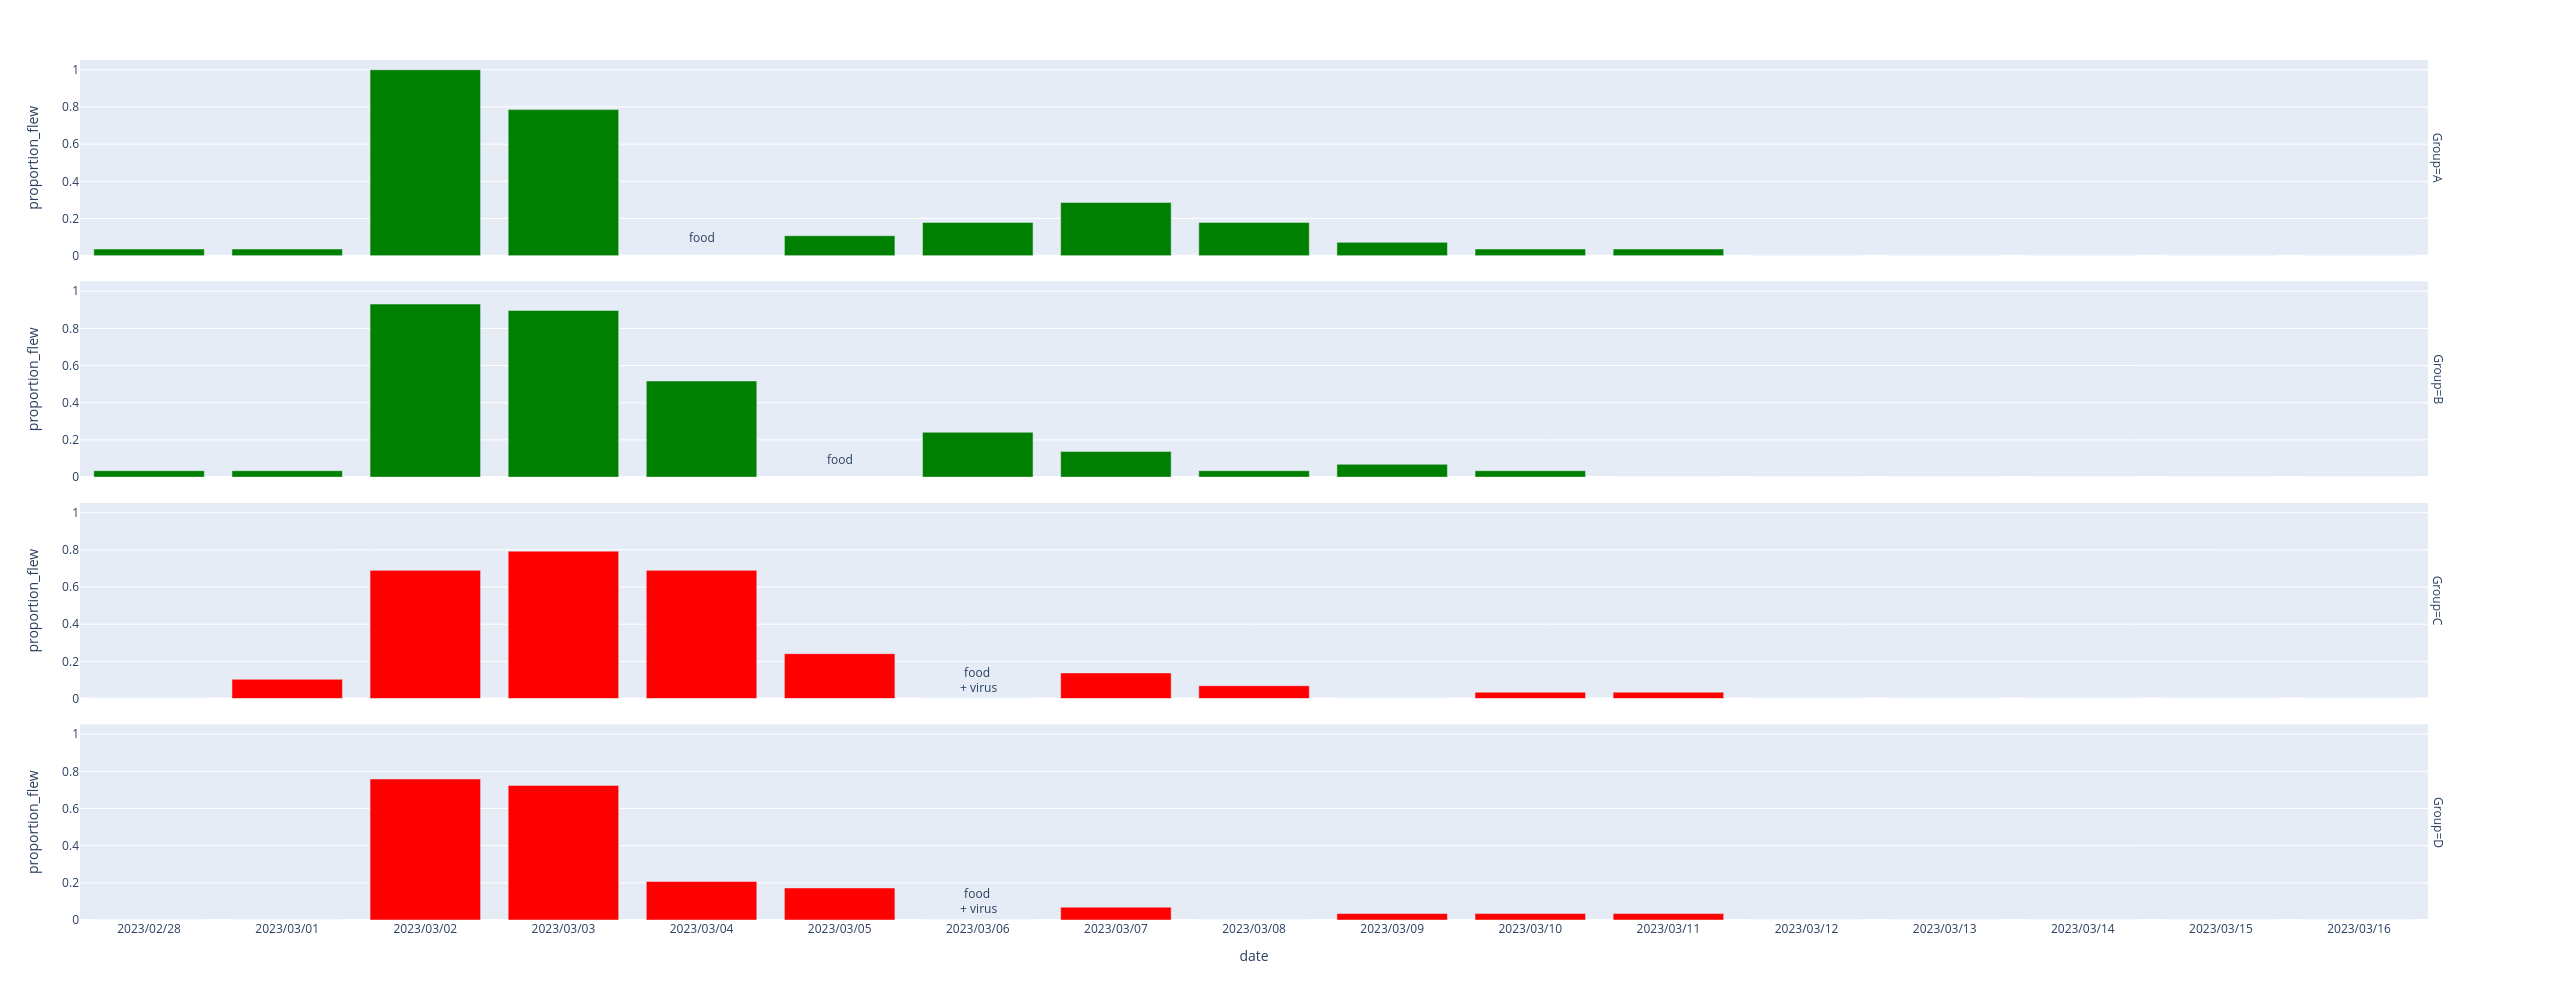

In [12]:
df = gb.reset_index().rename(columns={0:'proportion_flew'})

fig = px.bar(df, x='date', y='proportion_flew', facet_row='Group', color='Group', color_discrete_sequence=['green','green','red','red'])

fig.update_layout(showlegend=False, width=1000, height=1000)

fig.add_annotation(x='2023/03/06', y=0.1, xref="x1", yref="y1", text="food<br> + virus", showarrow=False, align="center")
fig.add_annotation(x='2023/03/06', y=0.1, xref="x2", yref="y2", text="food<br> + virus", showarrow=False, align="center")
fig.add_annotation(x='2023/03/05', y=0.1, xref="x3", yref="y3", text="food", showarrow=False, align="center")
fig.add_annotation(x='2023/03/04', y=0.1, xref="x4", yref="y4", text="food", showarrow=False, align="center")

fig.write_html("results.html")

fig.show()